In [1]:
'''
This script visualizes the outputs of the Gabor filters applied to the natural videos.
Author: Jonathan Gant
Date: 05.05.2025
'''

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
import os
import bottleneck as bn

# Set random seed for reproducibility
np.random.seed(0)

In [4]:
# load in the data
# all_gabor_responses = h5py.File('../results/new_nat_videos_gabor_responses_overlap_z_score_less_videos_for_visualization_field.h5', 'r')
all_gabor_responses = h5py.File('../results/new_nat_videos_gabor_responses_overlap_z_score_less_videos_for_visualization.h5', 'r')


# video size
resolution_height = 1080
resolution_width = 1920

# fov
horizontal_fov = 92
vertical_fov = 61

# conversion factor of pixels to degrees
horizontal_pixels_per_degree = resolution_width / horizontal_fov
vertical_pixels_per_degree = resolution_height / vertical_fov

# average of the conversion factors to the nearest integer
pixels_per_degree = np.ceil((horizontal_pixels_per_degree + vertical_pixels_per_degree) / 2)
print(pixels_per_degree)

# # data hyperparameters
orientation_arr = all_gabor_responses['orientation_arr'][()]
phase_arr = np.linspace(0, 270, 4)
position_arr = all_gabor_responses['position_arr'][()]
freq_arr = all_gabor_responses['freq_arr'][()]
wavelength_arr = pixels_per_degree/freq_arr
surround_distance = all_gabor_responses['surround_distance'][()]
displacement_arr = all_gabor_responses['displacement_arr'][()]
filter_size = (resolution_height, resolution_width)
print(freq_arr)

20.0
0.05


In [16]:
# parse the data and compute fourier transform for each filter and video
environment = 'forest' # 'forest' # ['field', 'forest', 'orchard', 'tall_grass', 'pond']

num_videos = 10
fps = 30
vid_length = 50*fps

stationary_stim = np.zeros((num_videos, len(orientation_arr), len(phase_arr), len(surround_distance), len(displacement_arr), vid_length))
moving_stim = np.zeros((num_videos, len(orientation_arr), len(phase_arr), len(surround_distance), len(displacement_arr), vid_length))

# get the responses for each environment
stationary_count = 0
moving_count = 0
all_gabor_responses_env = all_gabor_responses[environment]
print(all_gabor_responses_env.keys())
for vid_key in all_gabor_responses_env.keys():
    if 'stationary' in vid_key:
        stationary_stim[stationary_count, :, :, :, :, :] = all_gabor_responses_env[vid_key][()][:, :, :, :, :vid_length]
        stationary_count += 1
    if 'moving' in vid_key and 'free_moving' not in vid_key:
        moving_stim[moving_count, :, :, :, :, :] = all_gabor_responses_env[vid_key][()][:, :, :, :, :vid_length]
        moving_count += 1

<KeysViewHDF5 ['free_moving_1', 'free_moving_10', 'free_moving_2', 'free_moving_3', 'free_moving_4', 'free_moving_5', 'free_moving_6', 'free_moving_7', 'free_moving_8', 'free_moving_9', 'moving_1', 'moving_10', 'moving_2', 'moving_3', 'moving_4', 'moving_5', 'moving_6', 'moving_7', 'moving_8', 'moving_9', 'stationary_1', 'stationary_10', 'stationary_2', 'stationary_3', 'stationary_4', 'stationary_5', 'stationary_6', 'stationary_7', 'stationary_8', 'stationary_9']>


# Receptive field visualization

In [17]:
from decord import VideoReader
from decord import cpu


# load in the video data
def load_frame(fname, frame_idx=0):

    print("attempting to load the video " + fname)
    # create separate thread to load in the video frames
    try:
        vr = VideoReader(fname, ctx=cpu(0))
        print("successfully found the video")
        print('video frames:', len(vr))
    except:
        print("failed to find the video :(")

    frame = vr[frame_idx].asnumpy()
    grayscale_frame = np.mean(frame, axis=-1)

    return grayscale_frame

# load in the video data
def load_video(fname):
    video = []

    print("attempting to load the video " + fname)
    # create separate thread to load in the video frames
    try:
        vr = VideoReader(fname, ctx=cpu(0))
        print("successfully found the video")
        print('video frames:', len(vr))
    except:
        print("failed to find the video :(")

    for i in range(len(vr)):
        frame = vr[i].asnumpy()
        grayscale_frame = np.mean(frame, axis=-1)
        # normalize the mean of each frame
        # grayscale_frame -= np.mean(grayscale_frame)
        # downscale_frame = cv2.resize(grayscale_frame, (resolution_width, resolution_height), interpolation=cv2.INTER_AREA)
        video.append(grayscale_frame)

    # define as an array
    video = np.array(video)

    # video -= np.mean(video, axis=(1, 2), keepdims=True)
    
    # normalize the video
    video -= np.mean(video)
    video /= np.std(video)

    return video

attempting to load the video ../data/new_nat_videos/forest/stationary_1.MP4
successfully found the video
video frames: 1837


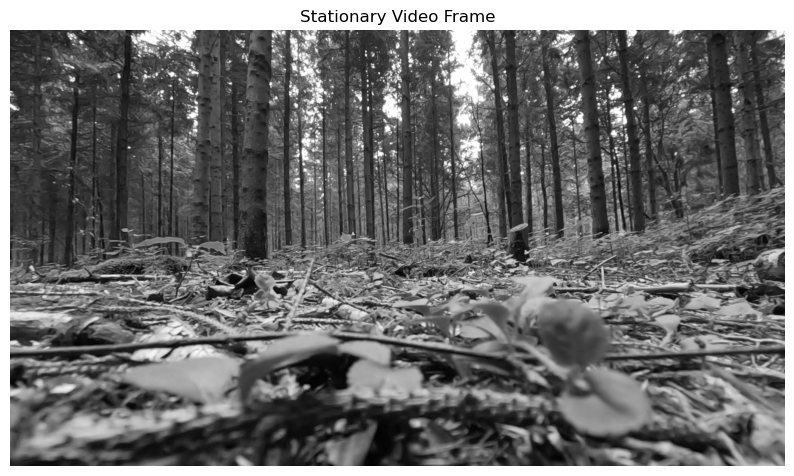

In [19]:
data_group = 'new_nat_videos'
data_dir = "../data/" + data_group + "/"
scene = 'forest/' # 'forest/'
video_idx_dict= {'1': 0, '10': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}

video_num = 1
frame_idx = 0
video_idx = video_idx_dict[str(video_num)]
fname = data_dir + scene + "stationary_" + str(video_num) + ".MP4"
# load in the video
video_frame = load_frame(fname, frame_idx)
# video = load_video(fname)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(video_frame, cmap='gray', vmin=0, vmax=255)
ax.axis('off')
ax.set_title('Stationary Video Frame')
plt.show()

# save the video frame as a pdf in a new directory called "video_frames"
if not os.path.exists('video_frames'):
    os.makedirs('video_frames')
fig.savefig(f'video_frames/{scene[:-1]}_{video_num}_frame_{frame_idx}.pdf', bbox_inches='tight', pad_inches=0.1, format='pdf')

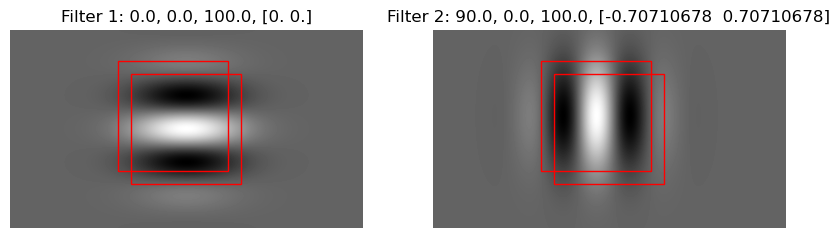

In [20]:
# define the Gabor filter function
def gabor_filter_func(
    sigma, theta, gamma, wavelength, phase, filt_size, x_offset=0, y_offset=0
):
    y, x = np.meshgrid(
        np.arange(filt_size[1]) - filt_size[1] // 2,
        np.arange(filt_size[0]) - filt_size[0] // 2,
    )
    x = x - x_offset
    y = y + y_offset
    x_prime = x * np.cos(np.pi * theta / 180) + y * np.sin(np.pi * theta / 180)
    y_prime = -x * np.sin(np.pi * theta / 180) + y * np.cos(np.pi * theta / 180)
    filter = np.exp(-0.5 * (x_prime**2 + (gamma * y_prime) ** 2) / sigma**2) * np.cos(
        2 * np.pi * x_prime / wavelength + np.pi * phase / 180)
    filter /= np.linalg.norm(filter)
    return filter

# orientation, phase, surround_distance, displacement
# (16, 4, 3, 9)
filter1_idx = [0, 0, 1, 0]
filter2_idx = [4, 0, 1, 2]

filter1 = gabor_filter_func(
        wavelength_arr/2,
        orientation_arr[filter1_idx[0]],
        1,
        wavelength_arr,
        phase_arr[filter1_idx[1]],
        (resolution_height, resolution_width),
        0+surround_distance[filter1_idx[2]]*displacement_arr[filter1_idx[3]][0],
        0+surround_distance[filter1_idx[2]]*displacement_arr[filter1_idx[3]][1],
    )

filter2 = gabor_filter_func(
        wavelength_arr/2,
        orientation_arr[filter2_idx[0]],
        1,
        wavelength_arr,
        phase_arr[filter2_idx[1]],
        (resolution_height, resolution_width),
        0+surround_distance[filter2_idx[2]]*displacement_arr[filter2_idx[3]][0],
        0+surround_distance[filter2_idx[2]]*displacement_arr[filter2_idx[3]][1]
    )

# plot the two filters
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(
    filter1,
    cmap='gray',
)
ax[0].axis('off')
ax[0].set_title(
    f"Filter 1: {orientation_arr[filter1_idx[0]]}, {phase_arr[filter1_idx[1]]}, {surround_distance[filter1_idx[2]]}, {displacement_arr[filter1_idx[3]]}"
)
ax[1].imshow(
    filter2,
    cmap='gray',
)
ax[1].axis('off')
ax[1].set_title(
    f"Filter 2: {orientation_arr[filter2_idx[0]]}, {phase_arr[filter2_idx[1]]}, {surround_distance[filter2_idx[2]]}, {displacement_arr[filter2_idx[3]]}"
)
# create a box around each of the filters
ax[0].add_patch(
    plt.Rectangle(
        (resolution_width//2-3*wavelength_arr/4-surround_distance[filter1_idx[2]]*displacement_arr[filter1_idx[3]][1], resolution_height//2-3*wavelength_arr/4+surround_distance[filter1_idx[2]]*displacement_arr[filter1_idx[3]][0]),
        1.5*wavelength_arr,
        1.5*wavelength_arr,
        linewidth=1,
        edgecolor='r',
        facecolor='none',
    )
)
ax[0].add_patch(
    plt.Rectangle(
        (resolution_width//2-3*wavelength_arr/4-surround_distance[filter2_idx[2]]*displacement_arr[filter2_idx[3]][1], resolution_height//2-3*wavelength_arr/4+surround_distance[filter2_idx[2]]*displacement_arr[filter2_idx[3]][0]),
        1.5*wavelength_arr,
        1.5*wavelength_arr,
        linewidth=1,
        edgecolor='r',
        facecolor='none',
    )
)
ax[1].add_patch(
    plt.Rectangle(
        (resolution_width//2-3*wavelength_arr/4-surround_distance[filter1_idx[2]]*displacement_arr[filter1_idx[3]][1], resolution_height//2-3*wavelength_arr/4+surround_distance[filter1_idx[2]]*displacement_arr[filter1_idx[3]][0]),
        1.5*wavelength_arr,
        1.5*wavelength_arr,
        linewidth=1,
        edgecolor='r',
        facecolor='none',
    )
)
ax[1].add_patch(
    plt.Rectangle(
        (resolution_width//2-3*wavelength_arr/4-surround_distance[filter2_idx[2]]*displacement_arr[filter2_idx[3]][1], resolution_height//2-3*wavelength_arr/4+surround_distance[filter2_idx[2]]*displacement_arr[filter2_idx[3]][0]),
        1.5*wavelength_arr,
        1.5*wavelength_arr,
        linewidth=1,
        edgecolor='r',
        facecolor='none',
    )
)
plt.show()


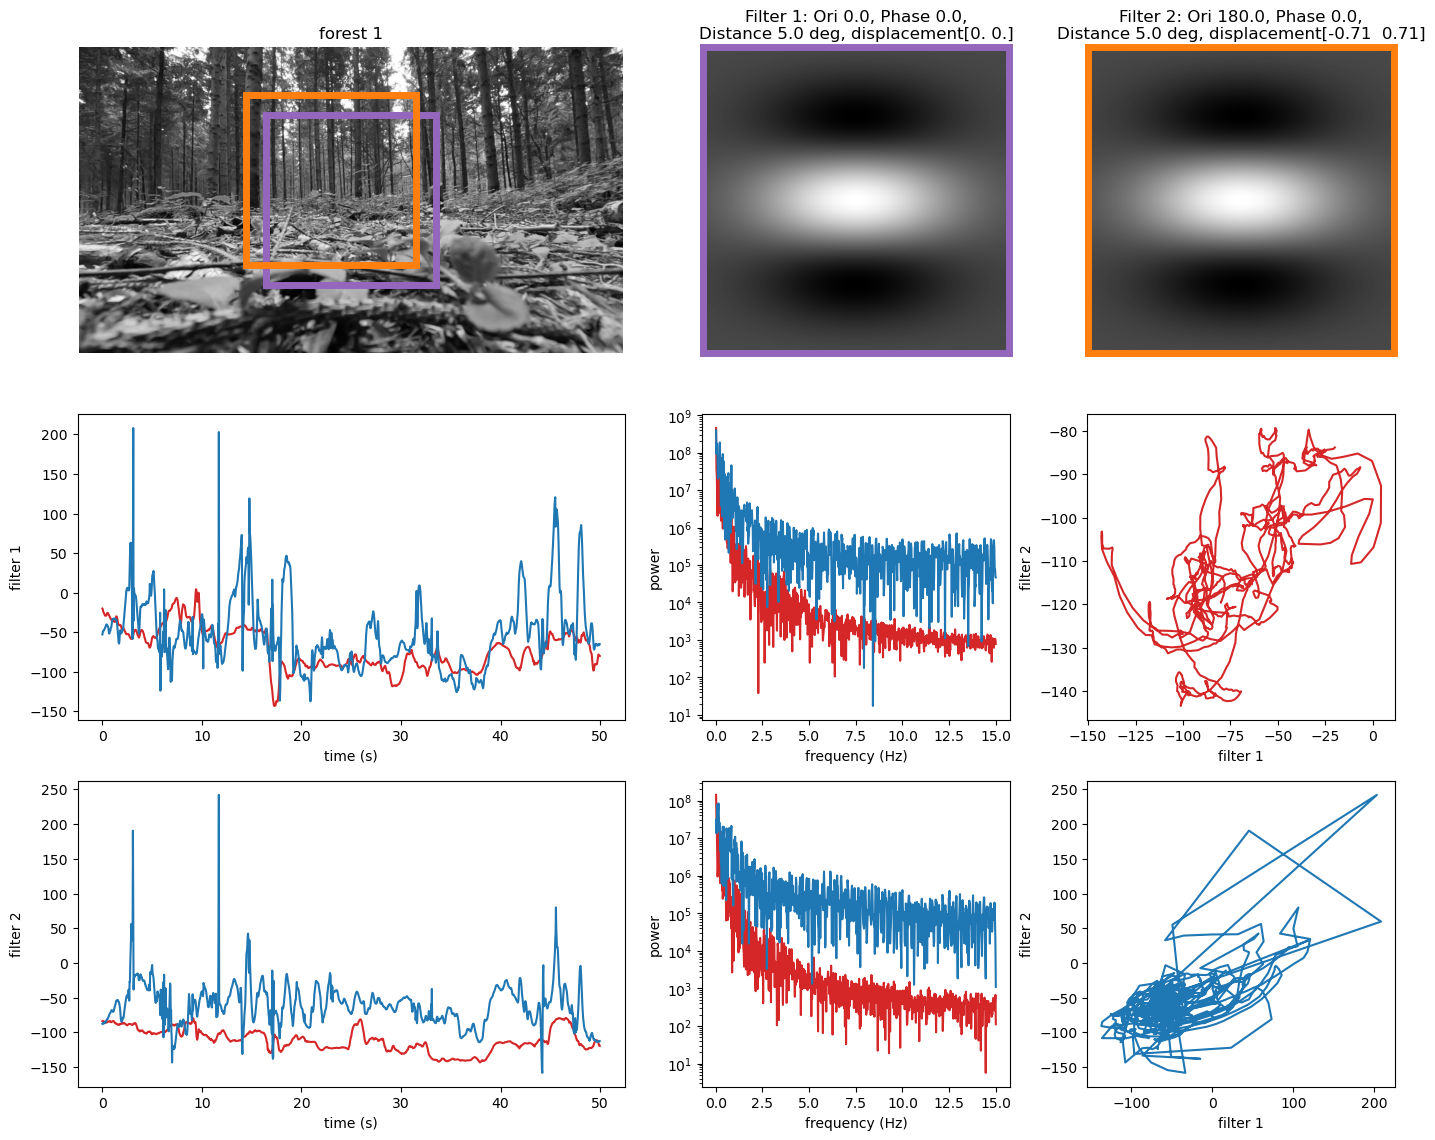

In [22]:
# import fourier transform
from scipy.fft import rfft, rfftfreq

# take subset of filter output for visualization
interval_length = 50*fps
# select a random point in the video
time_idx = 0# np.random.randint(0, vid_length-interval_length)

# define the Gabor filter function
def gabor_filter_func(
    sigma, theta, gamma, wavelength, phase, filt_size, x_offset=0, y_offset=0
):
    y, x = np.meshgrid(
        np.arange(filt_size[1]) - filt_size[1] // 2,
        np.arange(filt_size[0]) - filt_size[0] // 2,
    )
    x = x - x_offset
    y = y + y_offset
    x_prime = x * np.cos(np.pi * theta / 180) + y * np.sin(np.pi * theta / 180)
    y_prime = -x * np.sin(np.pi * theta / 180) + y * np.cos(np.pi * theta / 180)
    filter = np.exp(-0.5 * (x_prime**2 + (gamma * y_prime) ** 2) / sigma**2) * np.cos(
        2 * np.pi * x_prime / wavelength + np.pi * phase / 180)
    filter /= np.linalg.norm(filter)
    return filter

# orientation, phase, surround_distance, displacement
# (16, 4, 3, 9)
filter1_idx = [0, 0, 1, 0]
filter2_idx = [8, 0, 1, 2]

filter1 = gabor_filter_func(
        wavelength_arr/3,
        orientation_arr[filter1_idx[0]],
        1,
        wavelength_arr,
        phase_arr[filter1_idx[1]],
        (resolution_height, resolution_width),
        0+surround_distance[filter1_idx[2]]*displacement_arr[filter1_idx[3]][0],
        0+surround_distance[filter1_idx[2]]*displacement_arr[filter1_idx[3]][1],
    )

filter2 = gabor_filter_func(
        wavelength_arr/3,
        orientation_arr[filter2_idx[0]],
        1,
        wavelength_arr,
        phase_arr[filter2_idx[1]],
        (resolution_height, resolution_width),
        0+surround_distance[filter2_idx[2]]*displacement_arr[filter2_idx[3]][0],
        0+surround_distance[filter2_idx[2]]*displacement_arr[filter2_idx[3]][1]
    )

fig, ax = plt.subplots(3, 3, figsize=(8+4.5+4.5, 3*4.5), width_ratios=[8, 4.5, 4.5])
ax[0, 0].imshow(video_frame, cmap='gray')
ax[0, 0].axis('off')
ax[0, 0].add_patch(
    plt.Rectangle(
        (resolution_width//2-3*wavelength_arr/4-surround_distance[filter1_idx[2]]*displacement_arr[filter1_idx[3]][1], resolution_height//2-3*wavelength_arr/4+surround_distance[filter1_idx[2]]*displacement_arr[filter1_idx[3]][0]),
        1.5*wavelength_arr,
        1.5*wavelength_arr,
        linewidth=5,
        edgecolor='tab:purple',
        facecolor='none',
    )
)
ax[0, 0].add_patch(
    plt.Rectangle(
        (resolution_width//2-3*wavelength_arr/4-surround_distance[filter2_idx[2]]*displacement_arr[filter2_idx[3]][1], resolution_height//2-3*wavelength_arr/4+surround_distance[filter2_idx[2]]*displacement_arr[filter2_idx[3]][0]),
        1.5*wavelength_arr,
        1.5*wavelength_arr,
        linewidth=5,
        edgecolor='tab:orange',
        facecolor='none',
    )
)
ax[0, 0].set_title(f'{scene[:-1]} {video_num}')
ax[0, 1].imshow(filter1, cmap='gray')
# make the outline blue without adding patch
ax[0, 1].axis()
for spine in ax[0, 1].spines.values():
    spine.set_edgecolor('tab:purple')
    spine.set_linewidth(5)
ax[0, 1].set_xlim(
    resolution_width//2-1.5*wavelength_arr/2-surround_distance[filter1_idx[2]]*displacement_arr[filter1_idx[3]][1],
    resolution_width//2+1.5*wavelength_arr/2-surround_distance[filter1_idx[2]]*displacement_arr[filter1_idx[3]][1],
)
ax[0, 1].set_ylim(
    resolution_height//2-1.5*wavelength_arr/2+surround_distance[filter1_idx[2]]*displacement_arr[filter1_idx[3]][0],
    resolution_height//2+1.5*wavelength_arr/2+surround_distance[filter1_idx[2]]*displacement_arr[filter1_idx[3]][0],
)
ax[0, 2].set_xlim(
    resolution_width//2-1.5*wavelength_arr/2-surround_distance[filter2_idx[2]]*displacement_arr[filter2_idx[3]][1],
    resolution_width//2+1.5*wavelength_arr/2-surround_distance[filter2_idx[2]]*displacement_arr[filter2_idx[3]][1],
)
ax[0, 2].set_ylim(
    resolution_height//2-1.5*wavelength_arr/2+surround_distance[filter2_idx[2]]*displacement_arr[filter2_idx[3]][0],
    resolution_height//2+1.5*wavelength_arr/2+surround_distance[filter2_idx[2]]*displacement_arr[filter2_idx[3]][0],
)
ax[0, 2].imshow(filter2, cmap='gray')
for spine in ax[0, 2].spines.values():
    spine.set_edgecolor('tab:orange')
    spine.set_linewidth(5)
# remove ticks and labels
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])
ax[0, 2].set_title(
    f"Filter 2: Ori {orientation_arr[filter2_idx[0]]}, Phase {phase_arr[filter2_idx[1]]},\nDistance {surround_distance[filter2_idx[2]]/pixels_per_degree} deg, displacement{np.round(displacement_arr[filter2_idx[3]], 2)}"
)
ax[0, 1].set_title(
    f"Filter 1: Ori {orientation_arr[filter1_idx[0]]}, Phase {phase_arr[filter1_idx[1]]},\nDistance {surround_distance[filter1_idx[2]]/pixels_per_degree} deg, displacement{np.round(displacement_arr[filter1_idx[3]], 2)}"
)

# in the second row, plot the output of filter 1 in the first column, the temporal spectrum of filter 1 in the second column, and the output of filter1 and filter2 in the third column
ax[1, 0].plot(np.arange(0, vid_length/fps, 1/fps), stationary_stim[video_idx, filter1_idx[0], filter1_idx[1], filter1_idx[2], filter1_idx[3], :], color='tab:red') 
ax[1, 0].plot(np.arange(0, vid_length/fps, 1/fps), moving_stim[video_idx, filter1_idx[0], filter1_idx[1], filter1_idx[2], filter1_idx[3], :], color='tab:blue')
ax[1, 0].set_xlabel('time (s)')
ax[1, 0].set_ylabel('filter 1')

# compute fourier transform of the filter output
filter1_fourier_stat = rfft(stationary_stim[video_idx, filter1_idx[0], filter1_idx[1], filter1_idx[2], filter1_idx[3], :])
filter1_fourier_mov = rfft(moving_stim[video_idx, filter1_idx[0], filter1_idx[1], filter1_idx[2], filter1_idx[3], :])
ax[1, 1].plot(rfftfreq(vid_length, 1/fps)[1:], np.abs(filter1_fourier_stat[1:])**2, color='tab:red')
ax[1, 1].plot(rfftfreq(vid_length, 1/fps)[1:], np.abs(filter1_fourier_mov[1:])**2, color='tab:blue')
ax[1, 1].set_yscale('log')
ax[1, 1].set_xlabel('frequency (Hz)')
ax[1, 1].set_ylabel('power')

# for the last column, plot the output of filter 1 and filter 2 in the stationary condition
ax[1, 2].plot(stationary_stim[video_idx, filter1_idx[0], filter1_idx[1], filter1_idx[2], filter1_idx[3], time_idx:time_idx+interval_length], stationary_stim[video_idx, filter2_idx[0], filter2_idx[1], filter2_idx[2], filter2_idx[3], time_idx:time_idx+interval_length], color='tab:red')
ax[1,2].set_xlabel('filter 1')
ax[1,2].set_ylabel('filter 2')

ax[2, 0].plot(np.arange(0, vid_length/fps, 1/fps), stationary_stim[video_idx, filter2_idx[0], filter2_idx[1], filter2_idx[2], filter2_idx[3], :], color='tab:red')
ax[2, 0].plot(np.arange(0, vid_length/fps, 1/fps), moving_stim[video_idx, filter2_idx[0], filter2_idx[1], filter2_idx[2], filter2_idx[3], :], color='tab:blue')
ax[2, 0].set_xlabel('time (s)')
ax[2, 0].set_ylabel('filter 2')
# compute fourier transform of the filter output
filter2_fourier_stat = rfft(stationary_stim[video_idx, filter2_idx[0], filter2_idx[1], filter2_idx[2], filter2_idx[3], :])
filter2_fourier_mov = rfft(moving_stim[video_idx, filter2_idx[0], filter2_idx[1], filter2_idx[2], filter2_idx[3], :])
ax[2, 1].plot(rfftfreq(vid_length, 1/fps)[1:], np.abs(filter2_fourier_stat[1:])**2, color='tab:red')
ax[2, 1].plot(rfftfreq(vid_length, 1/fps)[1:], np.abs(filter2_fourier_mov[1:])**2, color='tab:blue')
ax[2, 1].set_yscale('log')
ax[2, 1].set_xlabel('frequency (Hz)')
ax[2, 1].set_ylabel('power')
# for the last column, plot the output of filter 1 and filter 2 in the moving condition
ax[2, 2].plot(moving_stim[video_idx, filter1_idx[0], filter1_idx[1], filter1_idx[2], filter1_idx[3], time_idx:time_idx+interval_length], moving_stim[video_idx, filter2_idx[0], filter2_idx[1], filter2_idx[2], filter2_idx[3], time_idx:time_idx+interval_length], color='tab:blue')
ax[2,2].set_xlabel('filter 1')
ax[2,2].set_ylabel('filter 2')

plt.show()

In [11]:
np.min(filter1)

-0.0023583328976549242

In [27]:
# from scipy.signal import welch

# # Compute the power spectral density using Welch's method
# frequencies, power_spectrum_stat = welch(
#     stationary_stim[video_idx, filter1_idx[0], filter1_idx[1], filter1_idx[2], filter1_idx[3], :],
#     fs=fps,
#     window='boxcar',
#     nperseg=interval_length,
#     noverlap=0,
#     nfft=interval_length,
#     scaling='spectrum'
# )
# frequencies, power_spectrum_mov = welch(
#     moving_stim[video_idx, filter1_idx[0], filter1_idx[1], filter1_idx[2], filter1_idx[3], :],
#     fs=fps,
#     window='boxcar',
#     nperseg=interval_length,
#     noverlap=0,
#     nfft=interval_length,
#     scaling='spectrum'
# )

# # Plot the smoothed spectra
# ax[1, 1].plot(frequencies[1:], power_spectrum_stat[1:], color='tab:red', label='Stationary')
# ax[1, 1].plot(frequencies[1:], power_spectrum_mov[1:], color='tab:blue', label='Moving')
# ax[1, 1].set_yscale('log')

In [ ]:
# from scipy.signal import windows
# from scipy.fft import rfft, rfftfreq
# import numpy as np

# # Parameters for DPSS tapers
# NW = 2.5  # Time-halfbandwidth product
# Kmax = np.floor(2*NW-1).astype(int)  # Number of tapers

# # Generate DPSS tapers
# tapers = windows.dpss(vid_length, NW, Kmax)

# # Function to compute multitaper spectrum
# def multitaper_spectrum(signal, tapers, fs):
#     spectra = []
#     for taper in tapers:
#         tapered_signal = signal * taper
#         spectrum = np.abs(rfft(tapered_signal))**2
#         spectra.append(spectrum)
#     # Average the spectra across tapers
#     avg_spectrum = np.mean(spectra, axis=0)
#     frequencies = rfftfreq(len(signal), 1/fs)
#     return frequencies, avg_spectrum

# # Compute multitaper spectrum for stationary and moving stimuli
# frequencies_stat, power_spectrum_stat = multitaper_spectrum(
#     stationary_stim[video_idx, filter1_idx[0], filter1_idx[1], filter1_idx[2], filter1_idx[3], :],
#     tapers,
#     fs=fps
# )
# frequencies_mov, power_spectrum_mov = multitaper_spectrum(
#     moving_stim[video_idx, filter1_idx[0], filter1_idx[1], filter1_idx[2], filter1_idx[3], :],
#     tapers,
#     fs=fps
# )

# # Plot the multitaper spectra
# ax[1, 2].plot(frequencies_stat[1:], power_spectrum_stat[1:], color='tab:red', label='Stationary')
# ax[1, 2].plot(frequencies_mov[1:], power_spectrum_mov[1:], color='tab:blue', label='Moving')
# ax[1, 2].set_yscale('log')

# Repeat for all pairs

In [23]:
import os
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# define the Gabor filter function
def gabor_filter_func(
    sigma, theta, gamma, wavelength, phase, filt_size, x_offset=0, y_offset=0
):
    y, x = np.meshgrid(
        np.arange(filt_size[1]) - filt_size[1] // 2,
        np.arange(filt_size[0]) - filt_size[0] // 2,
    )
    x = x - x_offset
    y = y + y_offset
    x_prime = x * np.cos(np.pi * theta / 180) + y * np.sin(np.pi * theta / 180)
    y_prime = -x * np.sin(np.pi * theta / 180) + y * np.cos(np.pi * theta / 180)
    filter = np.exp(-0.5 * (x_prime**2 + (gamma * y_prime) ** 2) / sigma**2) * np.cos(
        2 * np.pi * x_prime / wavelength + np.pi * phase / 180)
    filter /= np.linalg.norm(filter)
    return filter

norm = mcolors.CenteredNorm(halfrange=0.003)
fps = 30
window_length = 5*fps

# Create the output directory if it doesn't exist
output_dir = "figure1_5sec_forest_demean_norm"
os.makedirs(output_dir, exist_ok=True)

# Iterate over all possible pairs of filters
for ori1 in range(len(orientation_arr)//2):
    for phase1 in range(len(phase_arr)):
        # Filter 1 indices (displacement index is always 0)
        filter1_idx = [ori1, phase1, 0, 0]
                                # Generate Gabor filters
        filter1 = gabor_filter_func(
            wavelength_arr / 3,
            orientation_arr[filter1_idx[0]],
            1,
            wavelength_arr,
            phase_arr[filter1_idx[1]],
            (resolution_height, resolution_width),
            0 + surround_distance[filter1_idx[2]] * displacement_arr[filter1_idx[3]][0],
            0 + surround_distance[filter1_idx[2]] * displacement_arr[filter1_idx[3]][1],
        )
        for ori2 in range(len(orientation_arr)//2):
            for phase2 in range(len(phase_arr)):
                # check if either ori1 == ori2 or phase1 == phase2, then skip this one
                if ori1 == ori2 or phase1 == phase2:
                    continue
                else:
                    # check if file already exists
                    # Filter 2 indices
                    dist2 = 1
                    disp2 = 4
                    filename = f"filter1_ori{ori1}_phase{phase1}_dist0_disp0_filter2_ori{ori2}_phase{phase2}_dist{dist2}_disp{disp2}.pdf"
                    filepath = os.path.join(output_dir, filename)
                    if os.path.exists(filepath):
                        print(f"File {filepath} already exists, skipping...")
                        continue
                    else:
                        filter2_idx = [ori2, phase2, dist2, disp2]

                        filter2 = gabor_filter_func(
                            wavelength_arr / 3,
                            orientation_arr[filter2_idx[0]],
                            1,
                            wavelength_arr,
                            phase_arr[filter2_idx[1]],
                            (resolution_height, resolution_width),
                            0 + surround_distance[filter2_idx[2]] * displacement_arr[filter2_idx[3]][0],
                            0 + surround_distance[filter2_idx[2]] * displacement_arr[filter2_idx[3]][1],
                        )

                        # select a random time point in the video
                        time_idx = np.random.randint(0, vid_length - window_length)

                        # Create the figure
                        fig, ax = plt.subplots(3, 3, figsize=(8 + 4.5 + 4.5, 3 * 4.5), width_ratios=[8, 4.5, 4.5])
                        ax[0, 0].imshow(video_frame, cmap='gray',vmin=0, vmax=255)
                        ax[0, 0].axis('off')
                        ax[0, 0].add_patch(
                            plt.Rectangle(
                                (resolution_width // 2 - 3 * wavelength_arr / 4 - surround_distance[filter1_idx[2]] * displacement_arr[filter1_idx[3]][1],
                                    resolution_height // 2 - 3 * wavelength_arr / 4 + surround_distance[filter1_idx[2]] * displacement_arr[filter1_idx[3]][0]),
                                1.5 * wavelength_arr,
                                1.5 * wavelength_arr,
                                linewidth=5,
                                edgecolor='tab:purple',
                                facecolor='none',
                            )
                        )
                        ax[0, 0].add_patch(
                            plt.Rectangle(
                                (resolution_width // 2 - 3 * wavelength_arr / 4 - surround_distance[filter2_idx[2]] * displacement_arr[filter2_idx[3]][1],
                                    resolution_height // 2 - 3 * wavelength_arr / 4 + surround_distance[filter2_idx[2]] * displacement_arr[filter2_idx[3]][0]),
                                1.5 * wavelength_arr,
                                1.5 * wavelength_arr,
                                linewidth=5,
                                edgecolor='tab:orange',
                                facecolor='none',
                            )
                        )
                        ax[0, 0].set_title(f'{scene[:-1]} {video_num}')
                        ax[0, 1].imshow(filter1, cmap='gray', norm=norm)
                        for spine in ax[0, 1].spines.values():
                            spine.set_edgecolor('tab:purple')
                            spine.set_linewidth(5)
                        ax[0, 2].imshow(filter2, cmap='gray', norm=norm)
                        for spine in ax[0, 2].spines.values():
                            spine.set_edgecolor('tab:orange')
                            spine.set_linewidth(5)
                        ax[0, 1].set_xlim(
                            resolution_width//2-1.5*wavelength_arr/2-surround_distance[filter1_idx[2]]*displacement_arr[filter1_idx[3]][1],
                            resolution_width//2+1.5*wavelength_arr/2-surround_distance[filter1_idx[2]]*displacement_arr[filter1_idx[3]][1],
                        )
                        ax[0, 1].set_ylim(
                            resolution_height//2-1.5*wavelength_arr/2+surround_distance[filter1_idx[2]]*displacement_arr[filter1_idx[3]][0],
                            resolution_height//2+1.5*wavelength_arr/2+surround_distance[filter1_idx[2]]*displacement_arr[filter1_idx[3]][0],
                        )
                        ax[0, 2].set_xlim(
                            resolution_width//2-1.5*wavelength_arr/2-surround_distance[filter2_idx[2]]*displacement_arr[filter2_idx[3]][1],
                            resolution_width//2+1.5*wavelength_arr/2-surround_distance[filter2_idx[2]]*displacement_arr[filter2_idx[3]][1],
                        )
                        ax[0, 2].set_ylim(
                            resolution_height//2-1.5*wavelength_arr/2+surround_distance[filter2_idx[2]]*displacement_arr[filter2_idx[3]][0],
                            resolution_height//2+1.5*wavelength_arr/2+surround_distance[filter2_idx[2]]*displacement_arr[filter2_idx[3]][0],
                        )
                        # remove ticks and labels
                        ax[0, 1].set_xticks([])
                        ax[0, 1].set_yticks([])
                        ax[0, 2].set_xticks([])
                        ax[0, 2].set_yticks([])
                        ax[0, 2].set_title(
                            f"Filter 2: Ori {orientation_arr[filter2_idx[0]]}, Phase {phase_arr[filter2_idx[1]]},\nDistance {surround_distance[filter2_idx[2]]/pixels_per_degree} deg, displacement{np.round(displacement_arr[filter2_idx[3]], 2)}"
                        )
                        ax[0, 1].set_title(
                            f"Filter 1: Ori {orientation_arr[filter1_idx[0]]}, Phase {phase_arr[filter1_idx[1]]},\nDistance {surround_distance[filter1_idx[2]]/pixels_per_degree} deg, displacement{np.round(displacement_arr[filter1_idx[3]], 2)}"
                        )
                        
                        stat_stim_norm = stationary_stim[video_idx, filter1_idx[0], filter1_idx[1], filter1_idx[2], filter1_idx[3], time_idx:time_idx+window_length].copy()
                        mov_stim_norm = moving_stim[video_idx, filter1_idx[0], filter1_idx[1], filter1_idx[2], filter1_idx[3], time_idx:time_idx+window_length].copy()
                        stat_stim_norm -= np.mean(stat_stim_norm)
                        mov_stim_norm -= np.mean(mov_stim_norm)

                        stat_stim_norm2 = stationary_stim[video_idx, filter2_idx[0], filter2_idx[1], filter2_idx[2], filter2_idx[3], time_idx:time_idx+window_length].copy()
                        mov_stim_norm2 = moving_stim[video_idx, filter2_idx[0], filter2_idx[1], filter2_idx[2], filter2_idx[3], time_idx:time_idx+window_length].copy()
                        stat_stim_norm2 -= np.mean(stat_stim_norm2)
                        mov_stim_norm2 -= np.mean(mov_stim_norm2)
                        
                        # Plot filter outputs and spectra
                        ax[1, 0].plot(np.arange(0, window_length / fps, 1 / fps),
                                        stat_stim_norm, color='tab:gray')
                        ax[1, 0].plot(np.arange(0, window_length / fps, 1 / fps),
                                        mov_stim_norm, color='tab:orange')
                        ax[1, 0].set_xlabel('time (s)')
                        ax[1, 0].set_ylabel('filter 1')

                        filter1_fourier_stat = rfft(
                            stat_stim_norm)
                        filter1_fourier_mov = rfft(
                            mov_stim_norm)
                        ax[1, 1].plot(rfftfreq(window_length, 1 / fps)[1:], np.abs(filter1_fourier_stat[1:]) ** 2,
                                        color='tab:gray')
                        ax[1, 1].plot(rfftfreq(window_length, 1 / fps)[1:], np.abs(filter1_fourier_mov[1:]) ** 2,
                                        color='tab:orange')
                        ax[1, 1].set_yscale('log')
                        ax[1, 1].set_xlabel('frequency (Hz)')
                        ax[1, 1].set_ylabel('power')

                        # for the last column, plot the output of filter 1 and filter 2 in the stationary condition
                        ax[1, 2].plot(stat_stim_norm, stat_stim_norm2, color='tab:gray')
                        ax[1,2].set_xlabel('filter 1')
                        ax[1,2].set_ylabel('filter 2')
                        # also compute the correlation coefficient
                        corr_coef = np.corrcoef(stat_stim_norm, stat_stim_norm2)[0, 1]
                        ax[1,2].set_title(f'Correlation coefficient: {corr_coef:.2f}')

                        ax[2, 0].plot(np.arange(0, window_length / fps, 1 / fps),
                                        stat_stim_norm2, color='tab:gray')
                        ax[2, 0].plot(np.arange(0, window_length / fps, 1 / fps),
                                        mov_stim_norm2, color='tab:orange')
                        ax[2, 0].set_xlabel('time (s)')
                        ax[2, 0].set_ylabel('filter 2')

                        filter2_fourier_stat = rfft(
                            stat_stim_norm2)
                        filter2_fourier_mov = rfft(
                            mov_stim_norm2)
                        ax[2, 1].plot(rfftfreq(window_length, 1 / fps)[1:], np.abs(filter2_fourier_stat[1:]) ** 2,
                                        color='tab:gray')
                        ax[2, 1].plot(rfftfreq(window_length, 1 / fps)[1:], np.abs(filter2_fourier_mov[1:]) ** 2,
                                        color='tab:orange')
                        ax[2, 1].set_yscale('log')
                        ax[2, 1].set_xlabel('frequency (Hz)')
                        ax[2, 1].set_ylabel('power')
                        # for the last column, plot the output of filter 1 and filter 2 in the moving condition
                        ax[2, 2].plot(mov_stim_norm, mov_stim_norm2, color='tab:orange')
                        # also compute the correlation coefficient
                        corr_coef = np.corrcoef(mov_stim_norm, mov_stim_norm2)[0, 1]
                        ax[2, 2].set_title(f'Correlation coefficient: {corr_coef:.2f}')
                        ax[2,2].set_xlabel('filter 1')
                        ax[2,2].set_ylabel('filter 2')

                        # ax[1, 0].set_ylim(-1, 1)
                        # ax[2, 0].set_ylim(-1, 1)
                        # ax[1, 2].set_xlim(-1, 1)
                        # ax[1, 2].set_ylim(-1, 1)
                        # ax[2, 2].set_xlim(-1, 1)
                        # ax[2, 2].set_ylim(-1, 1)

                        plt.savefig(filepath)
                        plt.close(fig)